In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
import sys
Scripts_Folder = '/home/sheffieldlab/Desktop/NoReward/Scripts/BayesDecoder/'
sys.path.append(Scripts_Folder)


from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR23/'

frame_lick_stop = 5154
task_numframes = {'Task1': 15000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task1 is 76
Number of PlaceCells in Task2 is 48
Number of PlaceCells in Task3 is 90
Number of PlaceCells in Task4 is 68


### Load required Data - load actual running data

#### Control Data

In [7]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

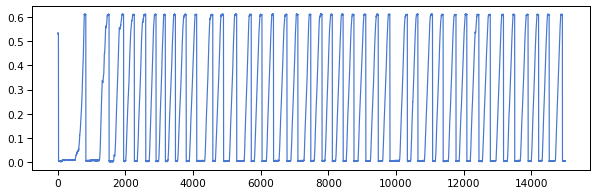

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [9]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

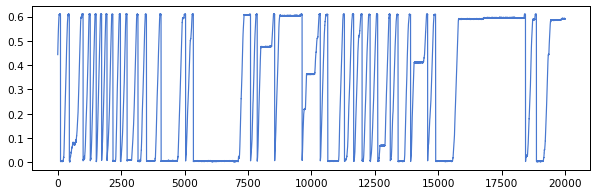

In [10]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

#### No Reward with good laps

In [11]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

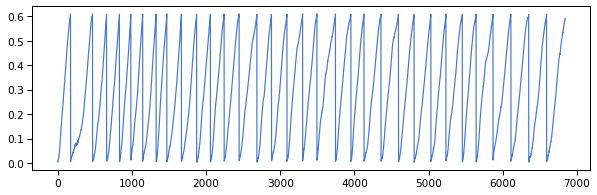

In [12]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

#### No reward with licks

In [13]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
lapswithlick = np.where(A.Parsed_Behavior['numlicks_withinreward'].item()['Task2']>0)[0]
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[lapswithlick]

### Compare velocity of tasks and select laps with comparable speeds

In [14]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0.3, after_stoplick=1)
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Chosen speeds
Number of chosen laps : Task1 : 40, Task2 : 19
Remainin laps in 12
Task1 [7.97288573 7.32730794 7.87604906 6.35894125 6.13298903 4.74499677
 4.51904454 5.2937379  7.16591349 5.22918012 5.81020013 5.97159458
 6.10071014 4.90639122 5.48741123 5.03550678 5.64880568 4.93867011
 4.77727566 5.74564235 5.26145901 6.03615236 5.55196901 5.5842479
 5.68108457 5.10006456 5.32601679 5.06778567 5.71336346 5.55196901
 5.42285345 5.68108457 6.42349903 5.74564235 5.35829567 5.26145901
 5.55196901 5.10006456 4.93867011 4.970949  ]
Task2 [6.22982569 5.13234345 4.68043899 5.13234345 5.68108457 4.38992899
 5.93931569 6.26210458 5.48741123 6.8431246  8.19883796 7.90832795
 7.03679793 6.68173015 6.64945126 6.68173015 6.81084571 6.93996127
 5.84247902]
Worst lap speeds Task2
[13.58941252 20.20658489 33.27953518 21.36862492  8.36023241  8.52162686
 12.55648806 20.8198838   9.74822466 90.54228535 11.91091026 23.36991607]


In [15]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 2]])
common_v_lapsB = np.array([i for i in common_v_lapsB if i not in [20, 23]])
worst_lapsB = np.array([i for i in worst_lapsB if i not in [22]])

Data shapes :  (8667, 379) (8667, 1)
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[11  3 23  4 15 20 19 22 17 28 26  7 37 24 29 36 13]
New data shapes :  (3736, 379) (3736, 1)


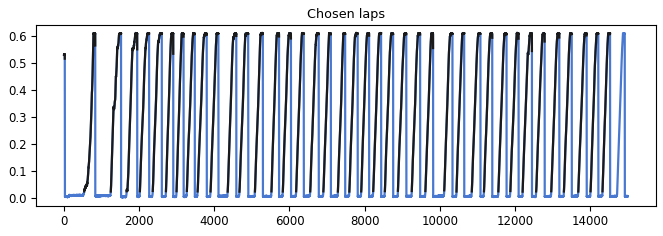

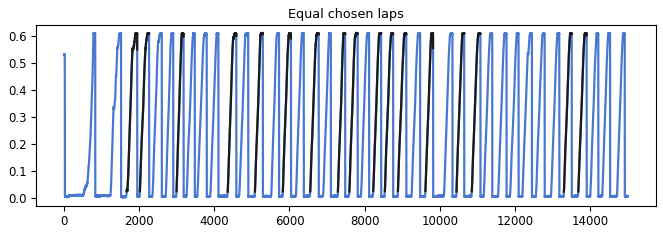

In [16]:
#Control Data
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (4022, 379) (4022, 1)


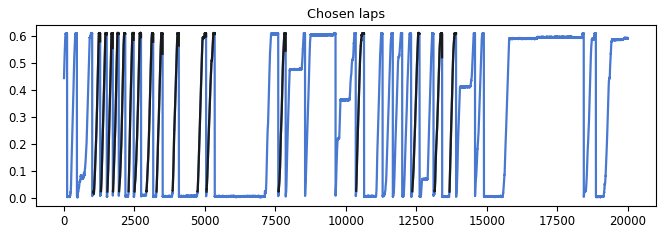

In [17]:
# Reward data with fast laps
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=2, figureflag=1)

Data shapes :  (2347, 379) (2347, 1)


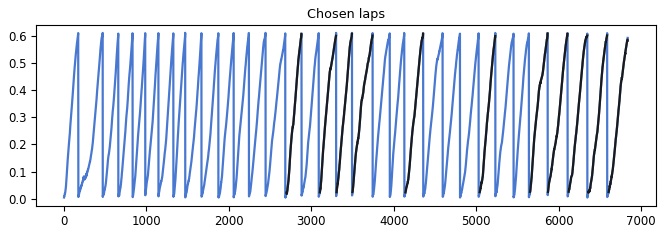

In [18]:
#Reward data with corrected laps
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)

### Shuffle Data and do k-fold validation

In [19]:
nsplits = 5
niteration = 100

#In order of tasks = 'Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps', 'NoReward_Lick'
figure_flag = 0 #For behavior
E_correction = [1, 2, 1, 1]

In [20]:
mean_R2 = {k: np.zeros(niteration)
           for k in ['Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps', 'NoReward_Lick']}
for i in np.arange(niteration):
    # Shuffle laps and pick up random laps each time to compile
    # Control
    X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected,
                                                             numlaps_topick=np.size(common_v_lapsB), 
                                                             E_correction=E_correction[0], figureflag=0)
    B = PreBeh(BehaviorData=Y_v_eq,
               tracklength=tracklength, trackbins=trackbins, figure_flag=figure_flag)
    y_v_eq_cat = B.position_binary

    # No Reward good laps
    X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(
        A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB,
        E_correction=E_correction[1], randomise=1, figureflag=0)
    B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength,
               trackbins=trackbins, trackstart_index=1, figure_flag=figure_flag)
    y_v_cat_norew = B.position_binary

    # No Reward worst laps
    X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB,
                                                                                       numlaps_topick=np.size(common_v_lapsB), 
                                                                                       E_correction=E_correction[2], lapcorrectionflag=1, figureflag=0)
    B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength,
               trackbins=trackbins, trackstart_index=1, figure_flag=figure_flag)
    y_norew_goodlaps_eq_cat = B.position_binary

    # No Reward before lick stops
    X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(
        A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=lapswithlick, randomise=1, E_correction=E_correction[3], lapcorrectionflag=1, figureflag=0)

    B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength,
               trackbins=trackbins, trackstart_index=0, figure_flag=figure_flag)
    y_v_new_lick_cat = B.position_binary

    # K-Fold validation
    controlcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=0)
    mean_R2['Control'][i] = np.mean(controlcv_dataframe['R2'])

    norewardcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Fastlaps'][i] = np.mean(norewardcv_dataframe['R2'])

    norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(
        X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Slowlaps'][i] = np.mean(norewardcv_goodlaps_dataframe['R2'])
    
    lickcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Lick'][i] = np.mean(lickcv_dataframe['R2'])

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[19  4  7 34  8 20 28 23 29 15 39 27 13 17 31 22 38]
New data shapes :  (3647, 379) (3647, 1)
Data shapes :  (4022, 379) (4022, 1)
[29 28 16 30 25 17 31 32 21 14 18]
[29 28 16 30 25 17 31 32 21 14 18]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2917, 379) (2917,) (730, 379) (730,)

Accuracy of test set:: 0.36%
Validation 2
(2917, 379) (2917,) (730, 379) (730,)

Accuracy of test set:: 0.35%
Validation 3
(2918, 379) (2918,) (729, 379) (729,)

Accuracy of test set:: 0.47%
Validation 4
(2918, 379) (2918,) (729, 379) (729,)

Accuracy of test set:: 0.44%
Validation 5
(2918, 379) (2918,) (729, 379) (729,)

Accuracy of test set:: 0.43%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.26%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[25 28 18 20 35 34 27 12 29 38 14  7  9 19 15 10  6]
New data shapes :  (3625, 379) (3625, 1)
Data shapes :  (4022, 379) (4022, 1)
[21 25 16 29 32 14 18 17 31 30 28]
[21 25 16 29 32 14 18 17 31 30 28]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2900, 379) (2900,) (725, 379) (725,)

Accuracy of test set:: 0.41%
Validation 2
(2900, 379) (2900,) (725, 379) (725,)

Accuracy of test set:: 0.42%
Validation 3
(2900, 379) (2900,) (725, 379) (725,)

Accuracy of test set:: 0.48%
Validation 4
(2900, 379) (2900,) (725, 379) (725,)

Accuracy of test set:: 0.37%
Validation 5
(2900, 379) (2900,) (725, 379) (725,)

Accuracy of test set:: 0.36%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.21%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy

Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.10%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[34 27 12 36 21 11  4 16 29 33 10 31 19 18 39 20  8]
New data shapes :  (3709, 379) (3709, 1)
Data shapes :  (4022, 379) (4022, 1)
[16 30 29 17 18 31 32 21 25 14 28]
[16 30 29 17 18 31 32 21 25 14 28]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2967, 379) (2967,) (742, 379) (742,)

Accuracy of test set:: 0.44%
Validation 2
(2967, 379) (2967,) (742, 379) (742,)

Accuracy of test set:: 0.38%
Validation 3
(2967, 379) (2967,) (742, 379) (742,)

Accuracy of test set:: 0.44%
Validation 4
(2967, 379) (2967,) (742, 379) (742,)

Accuracy of test set:: 0.43%
Validation 5
(2968, 379) (2968,) (741, 379) (741,)

Accuracy of test set:: 0.38%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy o

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[32 28 20 26 18  6 21 36  5 13 14 31 23  1 16 39 29]
New data shapes :  (3682, 379) (3682, 1)
Data shapes :  (4022, 379) (4022, 1)
[29 16 28 18 31 21 25 32 14 17 30]
[29 16 28 18 31 21 25 32 14 17 30]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2945, 379) (2945,) (737, 379) (737,)

Accuracy of test set:: 0.47%
Validation 2
(2945, 379) (2945,) (737, 379) (737,)

Accuracy of test set:: 0.40%
Validation 3
(2946, 379) (2946,) (736, 379) (736,)

Accuracy of test set:: 0.35%
Validation 4
(2946, 379) (2946,) (736, 379) (736,)

Accuracy of test set:: 0.33%
Validation 5
(2946, 379) (2946,) (736, 379) (736,)

Accuracy of test set:: 0.35%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.29%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy


Accuracy of test set:: 0.12%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.08%
Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.28%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[26 39  9 24  8 28 21  3 22 10  7 35 38 23 15 37 16]
New data shapes :  (3668, 379) (3668, 1)
Data shapes :  (4022, 379) (4022, 1)
[28 30 17 29 25 14 21 16 32 18 31]
[28 30 17 29 25 14 21 16 32 18 31]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2934, 379) (2934,) (734, 379) (734,)

Accuracy of test set:: 0.37%
Validation 2
(2934, 379) (2934,) (734, 379) (734,)

Accuracy of test set:: 0.41%
Validation 3
(2934, 379) (2934,) (734, 379) (734,)

Accuracy of test set:: 0.33%
Validation 4
(2935, 379) (2935,) (733, 379) (733,)

Accuracy of test set:: 0.41%
Validation 5
(2935, 379) (2935,) (733, 379) (733,)

Accuracy of

Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.07%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[30 14 37 12 33 31 11 32 18 29 27 19  9 20 15 38 26]
New data shapes :  (3727, 379) (3727, 1)
Data shapes :  (4022, 379) (4022, 1)
[17 30 32 28 29 21 31 18 16 25 14]
[17 30 32 28 29 21 31 18 16 25 14]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2981, 379) (2981,) (746, 379) (746,)

Accuracy of test set:: 0.42%
Validation 2
(2981, 379) (2981,) (746, 379) (746,)

Accuracy of test set:: 0.38%
Validation 3
(2982, 379) (2982,) (745, 379) (745,)

Accuracy of test set:: 0.45%
Validation 4
(2982, 379) (2982,) (745, 379) (745,)

Accuracy of test set:: 0.42%
Validation 5
(2982, 379) (2982,) (745, 379) (745,)

Accuracy of test set:: 0.45%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy o

Validation 3
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.17%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.18%
Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.28%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[27  8  3 13 36  6 35 16 12 39 33  1 23 24  7 15 11]
New data shapes :  (3798, 379) (3798, 1)
Data shapes :  (4022, 379) (4022, 1)
[29 25 14 17 28 18 32 31 16 30 21]
[29 25 14 17 28 18 32 31 16 30 21]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(3038, 379) (3038,) (760, 379) (760,)

Accuracy of test set:: 0.32%
Validation 2
(3038, 379) (3038,) (760, 379) (760,)

Accuracy of test set:: 0.33%
Validation 3
(3038, 379) (3038,) (760, 379) (760,)

Accuracy of test set:: 0.34%
Validation 4
(3039, 379) (3039,) (759, 379) (759,)

Accuracy of test set:: 0.29%
Validation 5
(


Accuracy of test set:: 0.19%
Validation 2
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.20%
Validation 3
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.07%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.25%
Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.08%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[14 37 38  6 10 17 25 18 11  1 12 23 34 21 19 36 27]
New data shapes :  (3719, 379) (3719, 1)
Data shapes :  (4022, 379) (4022, 1)
[18 17 25 28 16 31 29 30 21 14 32]
[18 17 25 28 16 31 29 30 21 14 32]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2975, 379) (2975,) (744, 379) (744,)

Accuracy of test set:: 0.38%
Validation 2
(2975, 379) (2975,) (744, 379) (744,)

Accuracy of test set:: 0.44%
Validation 3
(2975, 379) (2975,) (744, 379) (744,)

Accuracy of tes

Validation 4
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.14%
Validation 5
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.10%
Performing 5-fold validation
Validation 1
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.06%
Validation 2
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.06%
Validation 3
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.22%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.17%
Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.28%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[12  3  9  1 38 36 37 33 35 23 30 22 18 24 32 10  7]
New data shapes :  (3839, 379) (3839, 1)
Data shapes :  (4022, 379) (4022, 1)
[25 28 30 31 32 21 18 17 29 14 16]
[25 28 30 31 32 21 18 17 29 14 16]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold 

Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.14%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.16%
Validation 3
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.14%
Validation 4
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.13%
Validation 5
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.17%
Performing 5-fold validation
Validation 1
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.06%
Validation 2
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.13%
Validation 3
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.16%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.22%
Validation 5
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.19%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[10  7 13 22  4 32  6 39 

Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.23%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.28%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.27%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.09%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.19%
Validation 3
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.12%
Validation 4
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.11%
Validation 5
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.15%
Performing 5-fold validation
Validation 1
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.06%
Validation 2
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.17%
Validation 3
(814, 379) (814,) (203, 379) (203,)

Accuracy of test set:: 0.08%
Validation 4
(814, 379) (814,) (203, 379) (203,)

Accurac

Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.25%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.29%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.31%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.18%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.28%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.08%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.16%
Validation 3
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.15%
Validation 4
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.12%
Validation 5
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.16%
Performing 5-fold validation
Validation 1
(813, 379) (813,) (204, 379) (204,)

Accuracy of test set:: 0.09%
Validation 2
(813, 379) 


Accuracy of test set:: 0.41%
Validation 3
(3031, 379) (3031,) (758, 379) (758,)

Accuracy of test set:: 0.46%
Validation 4
(3031, 379) (3031,) (758, 379) (758,)

Accuracy of test set:: 0.42%
Validation 5
(3032, 379) (3032,) (757, 379) (757,)

Accuracy of test set:: 0.48%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.21%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.24%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.34%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.27%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.22%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.12%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.11%
Validation 3
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.12%
Validation 4
(1878, 3


Accuracy of test set:: 0.30%
Validation 3
(3012, 379) (3012,) (753, 379) (753,)

Accuracy of test set:: 0.36%
Validation 4
(3012, 379) (3012,) (753, 379) (753,)

Accuracy of test set:: 0.36%
Validation 5
(3012, 379) (3012,) (753, 379) (753,)

Accuracy of test set:: 0.44%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.32%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.23%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.29%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.14%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.27%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.14%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.13%
Validation 3
(1878, 379) (1878,) (469, 379) (469,)

Accuracy of test set:: 0.09%
Validation 4
(1878, 3


Accuracy of test set:: 0.39%
Validation 2
(2910, 379) (2910,) (728, 379) (728,)

Accuracy of test set:: 0.36%
Validation 3
(2910, 379) (2910,) (728, 379) (728,)

Accuracy of test set:: 0.45%
Validation 4
(2911, 379) (2911,) (727, 379) (727,)

Accuracy of test set:: 0.37%
Validation 5
(2911, 379) (2911,) (727, 379) (727,)

Accuracy of test set:: 0.38%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.28%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.28%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.25%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.24%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.24%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.19%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.15%
Validation 3
(1878, 3


Accuracy of test set:: 0.33%
Validation 2
(2978, 379) (2978,) (745, 379) (745,)

Accuracy of test set:: 0.37%
Validation 3
(2978, 379) (2978,) (745, 379) (745,)

Accuracy of test set:: 0.42%
Validation 4
(2979, 379) (2979,) (744, 379) (744,)

Accuracy of test set:: 0.39%
Validation 5
(2979, 379) (2979,) (744, 379) (744,)

Accuracy of test set:: 0.37%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.22%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.30%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.15%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.27%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.30%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.15%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.14%
Validation 3
(1878, 3


Accuracy of test set:: 0.41%
Validation 2
(3114, 379) (3114,) (779, 379) (779,)

Accuracy of test set:: 0.25%
Validation 3
(3114, 379) (3114,) (779, 379) (779,)

Accuracy of test set:: 0.37%
Validation 4
(3115, 379) (3115,) (778, 379) (778,)

Accuracy of test set:: 0.39%
Validation 5
(3115, 379) (3115,) (778, 379) (778,)

Accuracy of test set:: 0.40%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.26%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.28%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.25%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.26%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.28%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.17%
Validation 2
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of test set:: 0.13%
Validation 3
(1878, 3

[25 29 32 18 17 21 16 28 14 31 30]
[25 29 32 18 17 21 16 28 14 31 30]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(3015, 379) (3015,) (754, 379) (754,)

Accuracy of test set:: 0.37%
Validation 2
(3015, 379) (3015,) (754, 379) (754,)

Accuracy of test set:: 0.45%
Validation 3
(3015, 379) (3015,) (754, 379) (754,)

Accuracy of test set:: 0.41%
Validation 4
(3015, 379) (3015,) (754, 379) (754,)

Accuracy of test set:: 0.40%
Validation 5
(3016, 379) (3016,) (753, 379) (753,)

Accuracy of test set:: 0.44%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.20%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.27%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.30%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.21%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of t

Data shapes :  (4022, 379) (4022, 1)
[16 28 30 29 32 17 14 31 21 18 25]
[16 28 30 29 32 17 14 31 21 18 25]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(3004, 379) (3004,) (752, 379) (752,)

Accuracy of test set:: 0.38%
Validation 2
(3005, 379) (3005,) (751, 379) (751,)

Accuracy of test set:: 0.34%
Validation 3
(3005, 379) (3005,) (751, 379) (751,)

Accuracy of test set:: 0.33%
Validation 4
(3005, 379) (3005,) (751, 379) (751,)

Accuracy of test set:: 0.37%
Validation 5
(3005, 379) (3005,) (751, 379) (751,)

Accuracy of test set:: 0.42%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.25%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.26%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.32%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.28%
Validation 5
(3218, 379) (32

[17 25 21 16 32 31 30 29 18 14 28]
[17 25 21 16 32 31 30 29 18 14 28]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2966, 379) (2966,) (742, 379) (742,)

Accuracy of test set:: 0.42%
Validation 2
(2966, 379) (2966,) (742, 379) (742,)

Accuracy of test set:: 0.34%
Validation 3
(2966, 379) (2966,) (742, 379) (742,)

Accuracy of test set:: 0.44%
Validation 4
(2967, 379) (2967,) (741, 379) (741,)

Accuracy of test set:: 0.37%
Validation 5
(2967, 379) (2967,) (741, 379) (741,)

Accuracy of test set:: 0.43%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.22%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.26%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.33%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.25%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of t

Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2902, 379) (2902,) (726, 379) (726,)

Accuracy of test set:: 0.37%
Validation 2
(2902, 379) (2902,) (726, 379) (726,)

Accuracy of test set:: 0.39%
Validation 3
(2902, 379) (2902,) (726, 379) (726,)

Accuracy of test set:: 0.36%
Validation 4
(2903, 379) (2903,) (725, 379) (725,)

Accuracy of test set:: 0.43%
Validation 5
(2903, 379) (2903,) (725, 379) (725,)

Accuracy of test set:: 0.40%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.20%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.25%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.23%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.24%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.35%
Performing 5-fold validation
Validation 1
(1877, 379) (1877,) (470, 379) (470,)

Accuracy of te

Data shapes :  (4022, 379) (4022, 1)
[29 21 17 30 32 25 14 16 18 31 28]
[29 21 17 30 32 25 14 16 18 31 28]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2988, 379) (2988,) (748, 379) (748,)

Accuracy of test set:: 0.32%
Validation 2
(2989, 379) (2989,) (747, 379) (747,)

Accuracy of test set:: 0.41%
Validation 3
(2989, 379) (2989,) (747, 379) (747,)

Accuracy of test set:: 0.44%
Validation 4
(2989, 379) (2989,) (747, 379) (747,)

Accuracy of test set:: 0.32%
Validation 5
(2989, 379) (2989,) (747, 379) (747,)

Accuracy of test set:: 0.47%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.25%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.31%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.26%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.25%
Validation 5
(3218, 379) (32

Data shapes :  (4022, 379) (4022, 1)
[17 28 32 18 31 25 30 14 16 21 29]
[17 28 32 18 31 25 30 14 16 21 29]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2996, 379) (2996,) (749, 379) (749,)

Accuracy of test set:: 0.40%
Validation 2
(2996, 379) (2996,) (749, 379) (749,)

Accuracy of test set:: 0.37%
Validation 3
(2996, 379) (2996,) (749, 379) (749,)

Accuracy of test set:: 0.45%
Validation 4
(2996, 379) (2996,) (749, 379) (749,)

Accuracy of test set:: 0.42%
Validation 5
(2996, 379) (2996,) (749, 379) (749,)

Accuracy of test set:: 0.45%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.22%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.30%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.22%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.31%
Validation 5
(3218, 379) (32

[17 14 30 32 28 21 25 29 31 18 16]
[17 14 30 32 28 21 25 29 31 18 16]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(3069, 379) (3069,) (768, 379) (768,)

Accuracy of test set:: 0.32%
Validation 2
(3069, 379) (3069,) (768, 379) (768,)

Accuracy of test set:: 0.32%
Validation 3
(3070, 379) (3070,) (767, 379) (767,)

Accuracy of test set:: 0.42%
Validation 4
(3070, 379) (3070,) (767, 379) (767,)

Accuracy of test set:: 0.39%
Validation 5
(3070, 379) (3070,) (767, 379) (767,)

Accuracy of test set:: 0.45%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.18%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.26%
Validation 3
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.24%
Validation 4
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of test set:: 0.34%
Validation 5
(3218, 379) (3218,) (804, 379) (804,)

Accuracy of t


Accuracy of test set:: 0.19%
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[35 10 29 38  9 36 26 39 11  5 37  1 18 17 34 16 31]
New data shapes :  (3776, 379) (3776, 1)
Data shapes :  (4022, 379) (4022, 1)
[25 31 32 14 21 30 16 28 17 18 29]
[25 31 32 14 21 30 16 28 17 18 29]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(3020, 379) (3020,) (756, 379) (756,)

Accuracy of test set:: 0.42%
Validation 2
(3021, 379) (3021,) (755, 379) (755,)

Accuracy of test set:: 0.39%
Validation 3
(3021, 379) (3021,) (755, 379) (755,)

Accuracy of test set:: 0.39%
Validation 4
(3021, 379) (3021,) (755, 379) (755,)

Accuracy of test set:: 0.28%
Validation 5
(3021, 379) (3021,) (755, 379) (755,)

Accuracy of test set:: 0.44%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.24%
Validation 2
(3217, 379) (3217

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[11 33  7 25 14 28 15 18 32 30  3  5  6 19 13 24 36]
New data shapes :  (3706, 379) (3706, 1)
Data shapes :  (4022, 379) (4022, 1)
[25 18 16 28 21 31 17 14 30 29 32]
[25 18 16 28 21 31 17 14 30 29 32]
New data shapes :  (2347, 379) (2347, 1)
Data shapes :  (1017, 379) (1017, 1)
Performing 5-fold validation
Validation 1
(2964, 379) (2964,) (742, 379) (742,)

Accuracy of test set:: 0.38%
Validation 2
(2965, 379) (2965,) (741, 379) (741,)

Accuracy of test set:: 0.47%
Validation 3
(2965, 379) (2965,) (741, 379) (741,)

Accuracy of test set:: 0.45%
Validation 4
(2965, 379) (2965,) (741, 379) (741,)

Accuracy of test set:: 0.24%
Validation 5
(2965, 379) (2965,) (741, 379) (741,)

Accuracy of test set:: 0.41%
Performing 5-fold validation
Validation 1
(3217, 379) (3217,) (805, 379) (805,)

Accuracy of test set:: 0.24%
Validation 2
(3217, 379) (3217,) (805, 379) (805,)

Accuracy

In [21]:
R2 = pd.DataFrame.from_dict(mean_R2)
R2 = R2.melt(var_name='TaskName', value_name='R2')

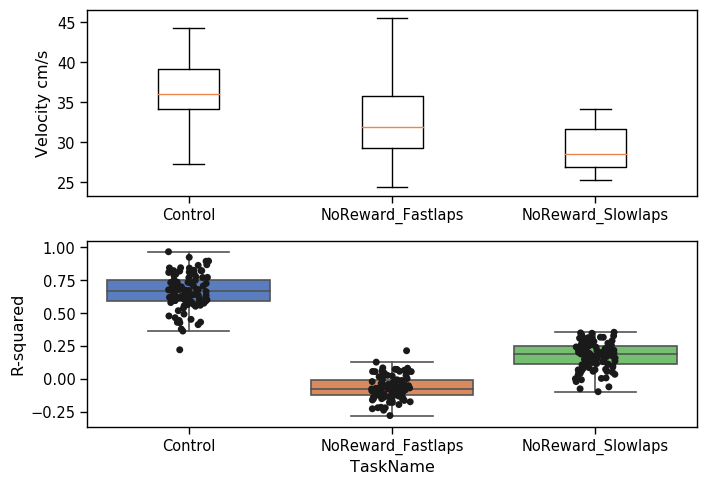

In [22]:
# No reward with lick only had 2 laps
fs, ax1 = plt.subplots(2, 1, figsize=(7, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps], showfliers=False)
ax1[0].set_xticklabels(['Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps'])
ax1[0].set_ylabel('Velocity cm/s')

sns.boxplot(x='TaskName', y='R2', data=R2[R2.TaskName!='NoReward_Lick'], ax=ax1[1], showfliers=False)
sns.stripplot(x='TaskName', y='R2', data=R2[R2.TaskName!='NoReward_Lick'], jitter=True, color='k', ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save results

In [23]:
#Save R-squared dataframe
R2.to_pickle(os.path.join(SaveResults, 'velocity_comparison_shuffle_R2.pkl'))